In [1]:
import torch
import os
from model import Generator
from argparse import Namespace
from torchvision import transforms, utils
from IPython.display import display
from PIL import Image

device = torch.device('cuda')

args = Namespace()
args.latent = 512
args.size = 1024
args.n_mlp = 8
args.channel_multiplier = 2

CODE_DIR = '/home/aiteam/tykim/encoder4editing'
oneshot_dir = '/home/aiteam/tykim/OneshotCLIP'

In [2]:
os.chdir(CODE_DIR)
from utils.common import tensor2im
from models.psp import pSp
from utils.alignment import align_face
import dlib
experiment_type = 'ffhq_encode'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)


model_path = '/home/aiteam/tykim/encoder4editing/pretrained_models/e4e_ffhq_encode.pt'
ckpt_e = torch.load(model_path, map_location='cpu')
opts = ckpt_e['opts']

opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net = net.cuda()

Loading e4e over the pSp framework from checkpoint: /home/aiteam/tykim/encoder4editing/pretrained_models/e4e_ffhq_encode.pt


In [3]:
#@title Function Settings

os.chdir(oneshot_dir)
def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True,resize=False)
    return images, latents

def run_alignment(image_path):
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor) 
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image 

In [18]:
os.system("wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
os.system("bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2")

0

Aligned image has shape: (256, 256)


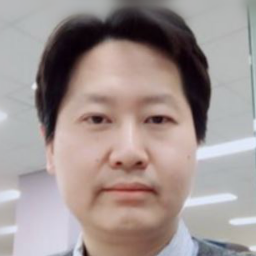

In [4]:
#@title Load test image & display
image_path = './test_img/park.jpg' 
sample_dir = '/home/aiteam/tykim/OneshotCLIP/samples/exp3'
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

test_image = transform(run_alignment(image_path).resize(resize_dims)).unsqueeze(0)

utils.save_image(
      test_image,
      f"%s/test_orig.png" % (sample_dir),
      nrow=1,
      normalize=True,
      range=(-1, 1),
  )
img = Image.open(os.path.join(sample_dir, 'test_orig.png')).resize((256, 256))
display(img)

In [7]:
# Pretrained Model
g_ema = Generator(args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier).to(device)
g_ema.eval()

ckpt_path = '/home/aiteam/tykim/OneshotCLIP/checkpoints/exp1/001000.pt'
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
g_ema.load_state_dict(ckpt["g_ema"], strict=False)

mix_idx = 11

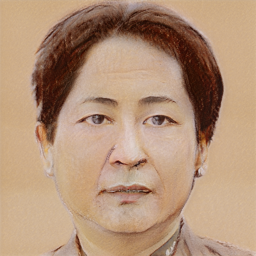

In [8]:
#@title Generate with new model
with torch.set_grad_enabled(False):
  net.eval()
  
  sample_many = torch.randn(10000,args.latent,device=device)
  w_many = g_ema.style(sample_many)
  w_mean = torch.mean(w_many,dim=0,keepdim=True).clone().detach()
  images, latents = run_on_batch(test_image, net)
  splat = list(latents[0].chunk(latents[0].size(0),dim=0))
  input_lat = splat[:mix_idx] + [w_mean]*(18-mix_idx)
  temp = torch.cat(input_lat,dim=0).unsqueeze(0)
  sample, _ = g_ema([temp],input_is_latent=True)
  utils.save_image(
      sample,
      f"%s/test_real.png" % (sample_dir),
      nrow=1,
      normalize=True,
      range=(-1, 1),
  )
  img = Image.open(os.path.join(sample_dir, 'test_real.png')).resize((256, 256))
  display(img)

In [2]:
# 소스 이미지의 Inversion w
code_path = '/home/aiteam/tykim/OneshotCLIP/test_img/son_3.pt'
latent = torch.load(code_path)['latent']

# Pretrained Model
g_ema = Generator(args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier).to(device)
g_ema.eval()

ckpt_path = '/home/aiteam/tykim/OneshotCLIP/checkpoints/exp2/001000.pt'
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
g_ema.load_state_dict(ckpt["g_ema"], strict=False)

<All keys matched successfully>

In [9]:
with torch.set_grad_enabled(False):
  mean_w = g_ema.get_latent(torch.randn([1, 512]).to(device)).unsqueeze(1).repeat(1, 18, 1)
  
  latents = latent.unsqueeze(0)
  in_latent = latents.clone()
  id_swap = list(range(3, g_ema.n_latent))
  alpha = 1.0
  in_latent[:, id_swap] = alpha * latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

  img, _ = g_ema(in_latent, input_is_latent=True)

  # im = utils.make_grid(img, normalize=True, range=(-1, 1))
  # display(im)
  print(img.shape)
  image = img.permute(1, 2, 0).detach().numpy()
  plt.figure()
  plt.title(title)
  plt.axis('off')
  plt.imshow(image)

torch.Size([18, 3, 1024, 1024])


RuntimeError: number of dims don't match in permute

In [ ]:
sample_many = torch.randn(10000,args.latent,device=device)
  w_many = g_ema.style(sample_many)
  w_mean = torch.mean(w_many,dim=0,keepdim=True).clone().detach()

  
  mix_idx = 11
  input_lat = latent
  temp = torch.cat(input_lat, dim=0).unsqueeze(0)
  sample, _ = g_ema([temp], input_is_latent=True)